In [152]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [153]:
sea.set_style("darkgrid")

In [154]:
data = pd.read_csv("diabetes.csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1
5,5,116,74,0,0,25.60,0.20,30,0
6,3,78,50,32,88,31.00,0.25,26,1
7,10,115,0,0,0,35.30,0.13,29,0
8,2,197,70,45,543,30.50,0.16,53,1
9,8,125,96,0,0,0.00,0.23,54,1


In [155]:
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Outcome"]
data_Y = data[["Outcome"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()


data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


In [156]:
data_Y["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [157]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

In [158]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.histplot(train_X.loc[train_Y["Outcome"]==0,feature],
                 kde = False, color = "#004a4d", bins=40,
                 label="Not Diabetes", ax=ax1);
    sea.histplot(train_X.loc[train_Y["Outcome"]==1,feature],
                 kde = False, color = "#7d0101", bins=40,
                 label="Diabetes", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");


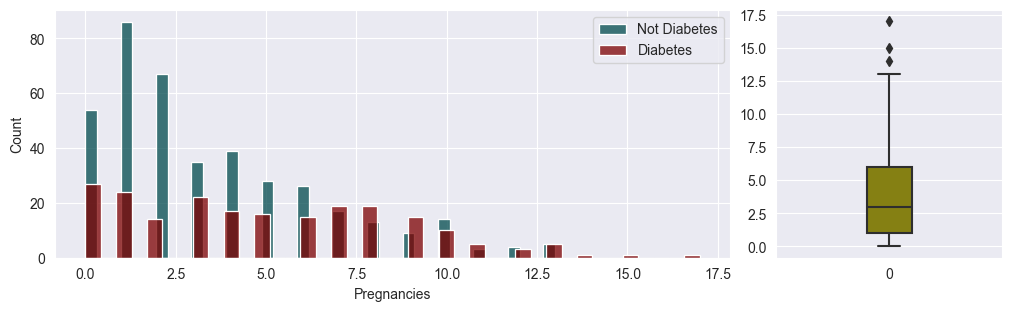

In [159]:
plots("Pregnancies")

In [160]:
Q1 = train_X["Pregnancies"].quantile(0.25)
Q3 = train_X["Pregnancies"].quantile(0.75)
q95th = train_X["Pregnancies"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Pregnancies"] = np.where(train_X["Pregnancies"] > UW,
                                  q95th, train_X["Pregnancies"])

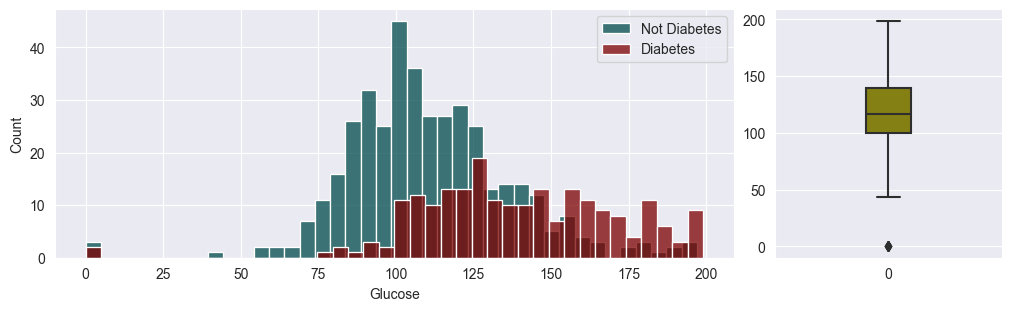

In [161]:
plots("Glucose")

In [162]:
med = train_X["Glucose"].median()
train_X["Glucose"] = np.where(train_X["Glucose"] == 0, med, train_X["Glucose"])

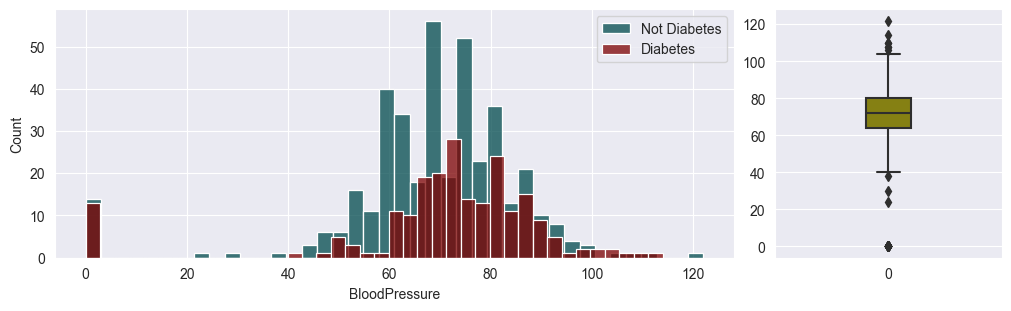

In [163]:
plots("BloodPressure")

In [164]:
med = train_X["BloodPressure"].median()
q5th = train_X["BloodPressure"].quantile(0.05)
q95th = train_X["BloodPressure"].quantile(0.95)
Q1 = train_X["BloodPressure"].quantile(0.25)
Q3 = train_X["BloodPressure"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["BloodPressure"] = np.where(train_X["BloodPressure"] == 0,
                                    med, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] < LW,
                                    q5th, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] > UW,
                                    q95th, train_X["BloodPressure"])

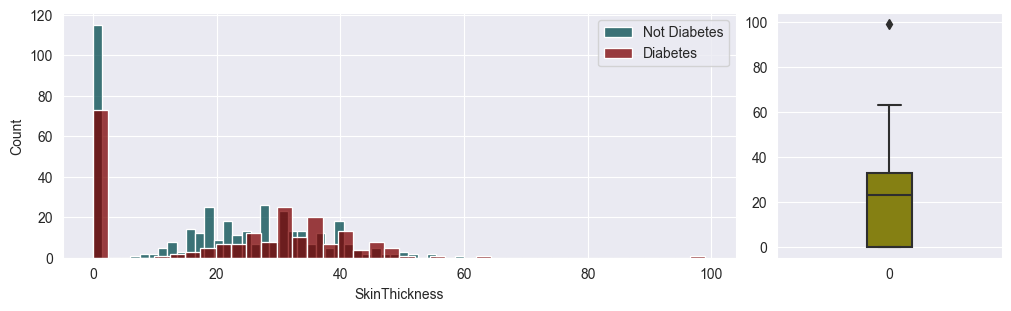

In [165]:
plots("SkinThickness")

In [166]:
med = train_X["SkinThickness"].median()
q95th = train_X["SkinThickness"].quantile(0.95)
Q1 = train_X["SkinThickness"].quantile(0.25)
Q3 = train_X["SkinThickness"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["SkinThickness"] = np.where(train_X["SkinThickness"] == 0,
                                    med, train_X["SkinThickness"])
train_X["SkinThickness"] = np.where(train_X["SkinThickness"] > UW,
                                    q95th, train_X["SkinThickness"])

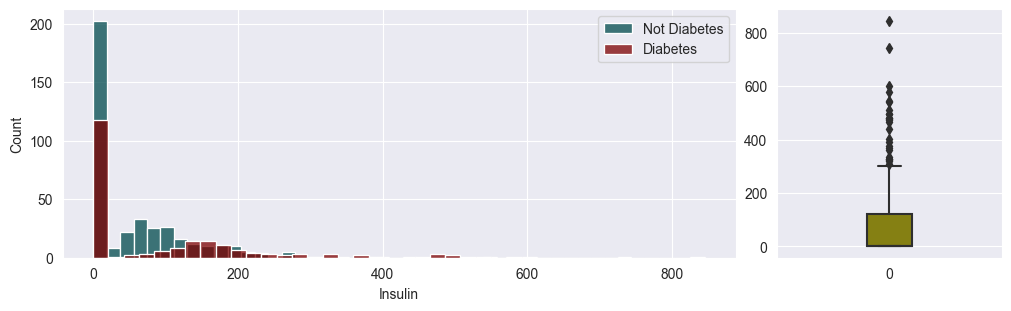

In [167]:
plots("Insulin")

In [168]:
q60th = train_X["Insulin"].quantile(0.60)
q95th = train_X["Insulin"].quantile(0.95)
Q1 = train_X["Insulin"].quantile(0.25)
Q3 = train_X["Insulin"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Insulin"] = np.where(train_X["Insulin"] == 0,
                              q60th, train_X["Insulin"])
train_X["Insulin"] = np.where(train_X["Insulin"] > UW,
                              q95th, train_X["Insulin"])

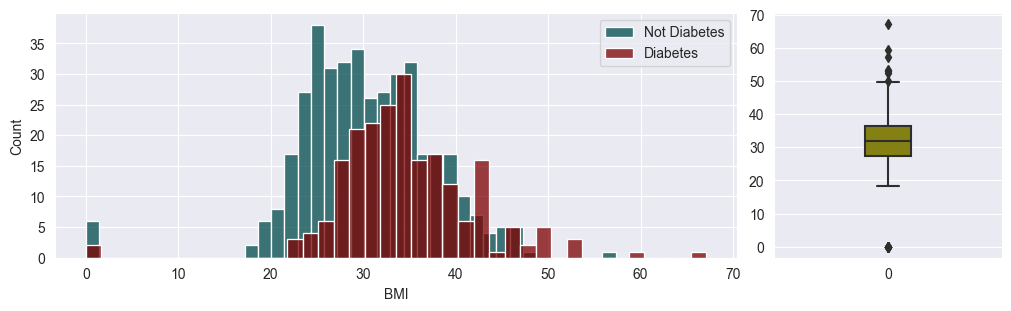

In [169]:
plots("BMI")

In [170]:
med = train_X["BMI"].median()
q95th = train_X["BMI"].quantile(0.95)
Q1 = train_X["BMI"].quantile(0.25)
Q3 = train_X["BMI"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BMI"] = np.where(train_X["BMI"] == 0,
                          med, train_X["BMI"])
train_X["BMI"] = np.where(train_X["BMI"] > UW,
                          q95th, train_X["BMI"])

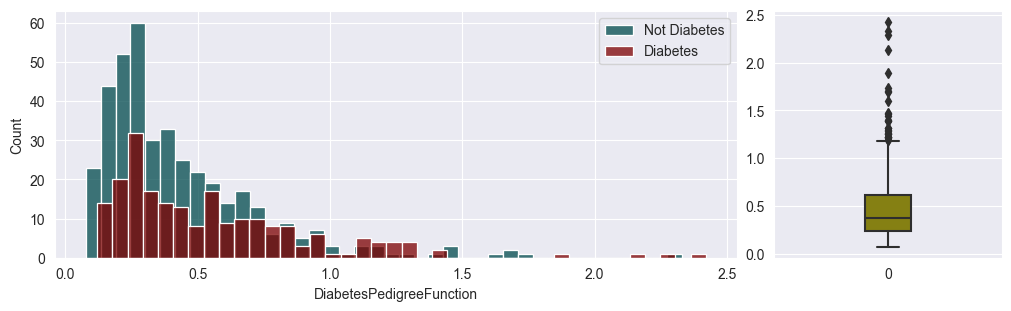

In [171]:
plots("DiabetesPedigreeFunction")

In [172]:
q95th = train_X["DiabetesPedigreeFunction"].quantile(0.95)
Q1 = train_X["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = train_X["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["DiabetesPedigreeFunction"] = np.where(
                        train_X["DiabetesPedigreeFunction"] > UW,
                        q95th, train_X["DiabetesPedigreeFunction"])

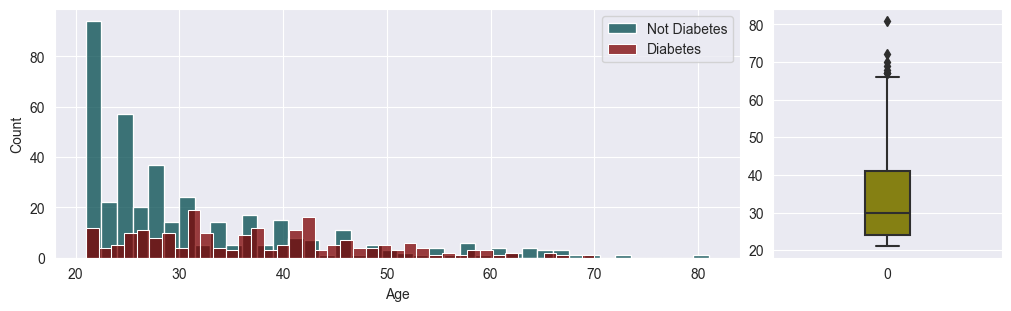

In [173]:
plots("Age")

In [174]:
q95th = train_X["Age"].quantile(0.95)
Q1 = train_X["Age"].quantile(0.25)
Q3 = train_X["Age"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Age"] = np.where(train_X["Age"] > UW,
                          q95th, train_X["Age"])

In [175]:
feature_names = train_X.columns

scaler = StandardScaler()

scaler.fit(train_X)

train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

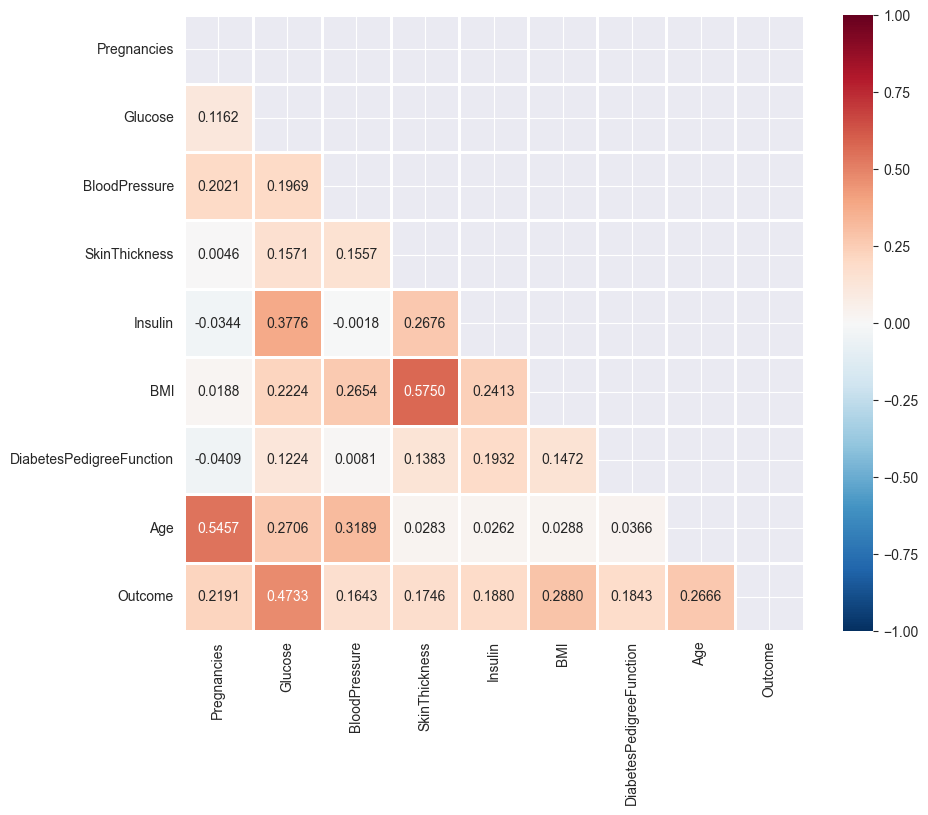

In [176]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

In [177]:
train_X.drop("SkinThickness", axis=1, inplace=True)
test_X.drop("SkinThickness", axis=1, inplace=True)

In [178]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

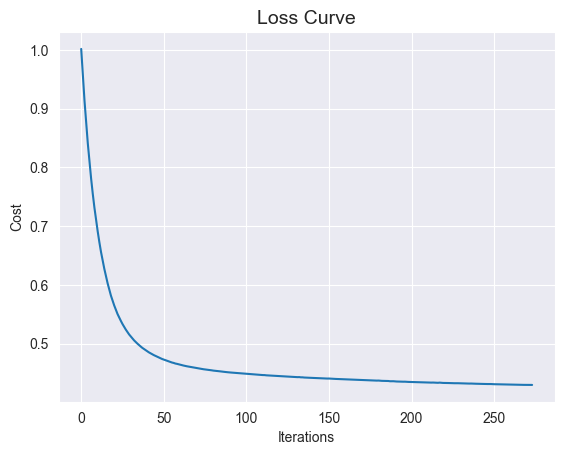

In [179]:
plt.plot(clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [189]:
clf.coefs_

[array([[ 0.29503411, -0.36781576,  0.03101906, -0.15990105,  0.20013886,
         -0.46078101, -0.54997692,  0.195905  ,  0.17432084, -0.31222628,
          0.09437462,  0.45457225],
        [-0.21411955,  0.3504265 , -0.69926649,  0.38342104,  0.40976054,
         -0.48565069,  0.27480846, -0.32383885,  0.15647058, -0.70927927,
         -0.62494564, -0.28940325],
        [-0.34784635, -0.10599447, -0.27894758, -0.28137263, -0.11084042,
         -0.22389343,  0.17088623, -0.21466816,  0.11088268,  0.19654718,
          0.36814515, -0.03617853],
        [ 0.0814942 , -0.22928007, -0.31902615, -0.15217075,  0.08143847,
          0.1646729 ,  0.13920151, -0.00327744,  0.01620195, -0.00905914,
          0.1919412 ,  0.11614166],
        [ 0.17431354,  0.66044206, -0.5089264 , -0.02916693,  0.29766627,
         -0.03748159,  0.27720562, -0.22070263,  0.34811963, -1.17185781,
          0.86260972,  0.51712127],
        [ 0.42590587,  0.18960295, -0.09909839, -0.19492478, -0.12133846,
      

In [180]:
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX: ")
mat = confusion_matrix(test_Y, clf.predict(test_X))
mat

CONFUSION MATRIX: 


array([[94,  6],
       [15, 39]])

In [181]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["Not Diabetes",
                                          "Diabetes"]))


              precision    recall  f1-score   support

Not Diabetes     0.8624    0.9400    0.8995       100
    Diabetes     0.8667    0.7222    0.7879        54

    accuracy                         0.8636       154
   macro avg     0.8645    0.8311    0.8437       154
weighted avg     0.8639    0.8636    0.8604       154



In [182]:
tn, fp, fn, tp = mat[0][0], mat[0][1], mat[1][0], mat[1][1]

In [183]:
accuracy = (tn + tp)/(tn + tp + fn + fp)
print("accuracy: ", accuracy)

accuracy:  0.8636363636363636


In [190]:
new_input = [[-0.58, -2.19, -1.43, -0.85, -1.26, -0.45, -0.99]]
ans = clf.predict(new_input)[0]
if ans == 0:
    print("No Diabetes")
else:
    print("Diabetes")

No Diabetes


In [195]:
new_input = [[0.31, 1.48, 0.29, -1.56, 2.11, -0.42, -0.55]]
ans = clf.predict(new_input)[0]
if ans == 0:
    print("No Diabetes")
else:
    print("Diabetes")

Diabetes
